In [1]:
import cv2
import numpy as np
from tools.ImageOperate import clahe_equalize, hist_cut
from location.GradMorph import find_barcode_by_diff
import matplotlib.pyplot as plt

# 读入图片并显示

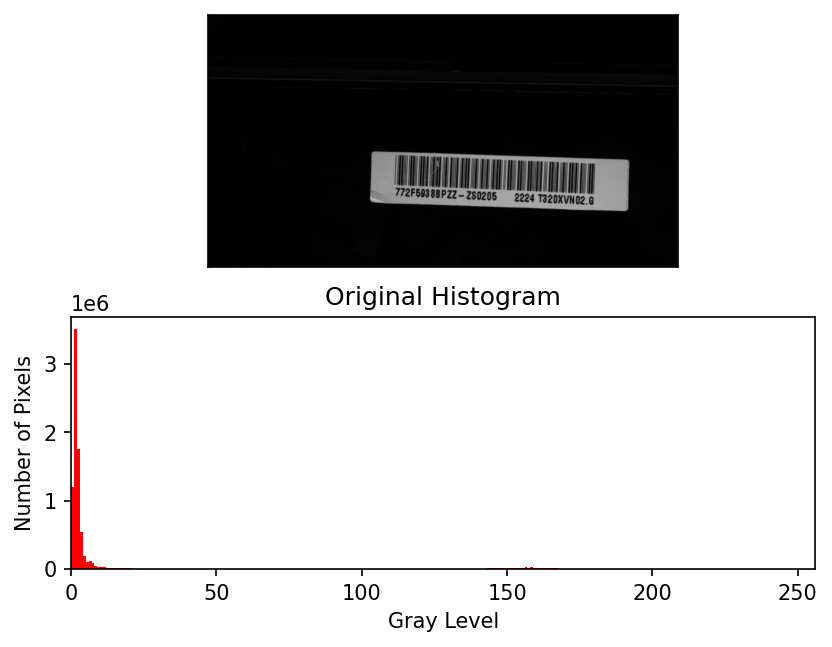

In [2]:
file = r"D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Factory\Defect_030.png"
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
plt.figure(dpi=150)
plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
plt.subplot(2, 1, 2)
plt.hist(image_source.ravel(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.xlabel('Gray Level')
plt.ylabel('Number of Pixels')
plt.title('Original Histogram')
plt.show()

# 图像金字塔

(311, 580, 3)


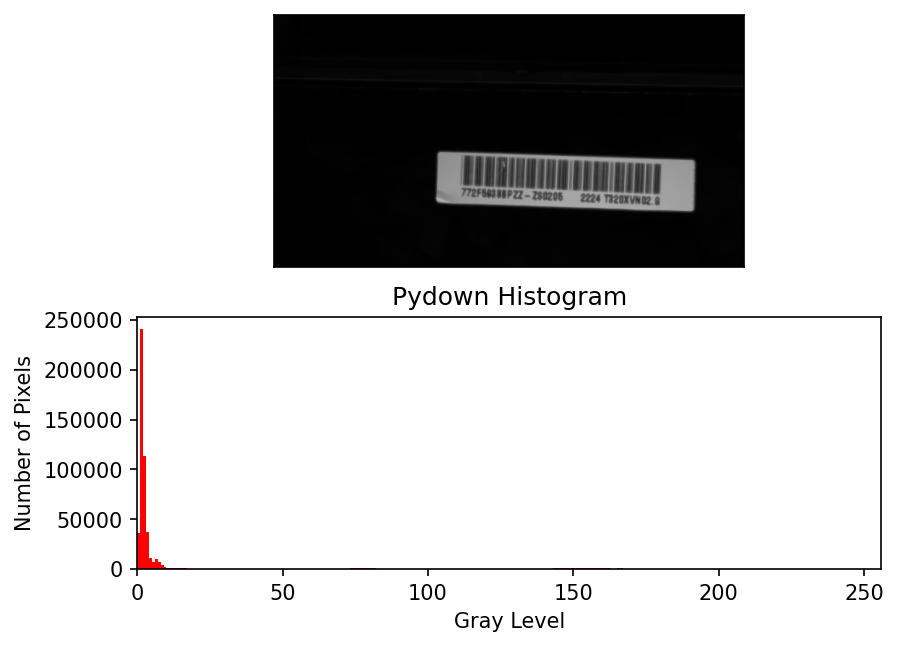

In [3]:
from tools.ImageOperate import build_laplacian_pyramid, reconstruct_from_laplacian_pyramid

laplacian_pyramid = build_laplacian_pyramid(image_source)
image_pydown_s = reconstruct_from_laplacian_pyramid(laplacian_pyramid, 2)

# image_pydown_s = image_pydown[-1]
print(image_pydown_s.shape)

plt.figure(dpi=150)
plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(image_pydown_s)

plt.subplot(2, 1, 2)
plt.hist(image_pydown_s.ravel(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.xlabel('Gray Level')
plt.ylabel('Number of Pixels')
plt.title('Pydown Histogram')
plt.show()

# 去除异常亮块

## 阈值分割

In [ ]:
image_gray = cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2GRAY)
ret, image_threshold = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(image_threshold, 'gray')
plt.show()

## 直线检测

In [ ]:
area_threshold = int(image_gray.shape[0] * image_gray.shape[1] * 0.015)
print("area_threshold:{}".format(area_threshold))

contours1, hierarchy1 = cv2.findContours(image_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

lsd = cv2.createLineSegmentDetector()
lines_list1 = []

for contour1 in contours1:
	x, y, w, h = cv2.boundingRect(contour1)
	if cv2.contourArea(contour1) > area_threshold:
		image_gray_part = image_gray[y:y + h, x:x + w]
		ret1, image_threshold1 = cv2.threshold(image_gray_part, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
		# detect lines1
		lines1, width, prec, nfa = lsd.detect(image_threshold1)
		if lines1 is not None:
			if lines1.shape[0] < 70:
				cv2.drawContours(image_gray, [contour1], -1, 0, cv2.FILLED)
			else:
				pass
			lines_list1.append(lines1)
	else:
		cv2.drawContours(image_gray, [contour1], -1, 0, cv2.FILLED)
# image_draw = cv2.minAreaRect([contours1],(0, 0, 255))
plt.xticks([])
plt.yticks([])
plt.imshow(image_gray, 'gray')
plt.show()

# 灰度重映射

In [ ]:
imax = np.max(image_gray)
image_equalized = (255 ** (image_gray / imax)).astype(np.uint8)
plt.figure(dpi=200)
plt.subplot(2, 2, 1)
plt.hist(image_gray.ravel(), 256, [0, 256], color='r')
plt.subplot(2, 2, 2)
plt.hist(image_equalized.ravel(), 256, [0, 256], color='r')

plt.subplot(2, 2, 3)
plt.imshow(image_gray, 'gray')
plt.subplot(2, 2, 4)
plt.imshow(image_equalized, 'gray')
plt.show()

# 条码区域定位

In [ ]:
r, t = cv2.threshold(image_equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(t, 'gray')
plt.show()

In [ ]:
kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(t, cv2.MORPH_CLOSE, kernel)  #闭运算

contours1, hierarchy1 = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

lines_list2 = []
for contour2 in contours1:
	x, y, w, h = cv2.boundingRect(contour2)
	if cv2.contourArea(contour2) > area_threshold:

		image_gray_part = image_gray[y:y + h, x:x + w]

		ret2, image_threshold2 = cv2.threshold(image_gray_part, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

		# detect lines_list
		lines, width, prec, nfa = lsd.detect(image_threshold2)
		if lines is not None:
			if lines.shape[0] < 70:
				cv2.drawContours(image_gray, [contour2], -1, 0, cv2.FILLED)
			else:
				# for line in lines:
				# 	# 获取线段的起点和终点坐标
				# 	x1, y1, x2, y2 = line[0].astype(int)
				# 	# 绘制线段
				# 	cv2.line(image_pydown_s, (x + x1, y + y1), (x + x2, y + y2), (0, 255, 0), 2)
				cv2.drawContours(image_pydown_s, [contour2], -1, (0, 255, 0, 1))
			lines_list2.append(lines)
	else:

		cv2.drawContours(image_gray, [contour2], -1, 0, cv2.FILLED)
plt.figure(dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image_pydown_s, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
def image_pyramid(image, levels):
	pyramid = [image]
	for i in range(1, levels):
		# 对前一层图像进行降采样
		downsampled = cv2.pyrDown(pyramid[i - 1])
		pyramid.append(downsampled)
	return pyramid


def image_reconstruct(pyramid):
	levels = len(pyramid)
	reconstructed = pyramid[levels - 1]
	for i in range(levels - 2, -1, -1):
		# 对下一层图像进行上采样，并与当前层金字塔图像相加
		upsampled = cv2.pyrUp(reconstructed, dstsize=pyramid[i].shape[:2][::-1])
		reconstructed = cv2.add(pyramid[i], upsampled)
	return reconstructed


# 读取图像
image = cv2.imread(r"D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Factory\Defect_030.png")

# 创建高斯金字塔
pyramid = image_pyramid(image, levels=3)

# 重建原始图像
reconstructed_image = image_reconstruct(pyramid)
cv2.imwrite(r"C:\Users\fy.xie\Desktop\output.png", reconstructed_image)
# 显示原始图像和重建后的图像
plt.figure(dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
for i in range(4, -1, -1):
	print(i)
